## Gather

Data will need to be gathered from several different locations to obtain all of the necessary information for this project.
1. The WeRateDogs Twitter archive (twitter-archive-enhanced.csv) - this is a file that is directly accessible
2. The tweet image predictions (image_predictions.tsv) - this is hosted on Udacity's server
3. Additional tweet information - this can be obtained by querying the Twitter API using Tweepy

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import requests
import os
import json
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# read the twitter archive into a data frame
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# grab the image predictions using Udacity's url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
# save the file as 'image-predictions.tsv' from the content of 'response'
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
# read the newly created image-predictions.tsv file into a data frame
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# get a list of all the tweet IDs for which we will want more data
twitter_archive.tweet_id.size, image_predictions.tweet_id.size

(2356, 2075)

Are all of the tweets in image_predictions also in twitter_archive? I will want a full list of tweet IDs before doing the next part of the process.

In [6]:
# there are 2356 unique tweet IDs in twitter_archive, and 2075 unique tweet IDs in image_predictions
twitter_archive.tweet_id.unique().size, image_predictions.tweet_id.unique().size

(2356, 2075)

In [7]:
# concatenate the tweet IDs from twitter_archive and image_predictions
all_IDs = pd.concat([twitter_archive.tweet_id, image_predictions.tweet_id])
all_IDs.size, all_IDs.unique().size

(4431, 2356)

So, the list of tweet IDs from twitter_archive includes all of the tweet IDs from image_prediction.

In [8]:
# list of unique tweet IDs
unique_tweet_IDs = twitter_archive.tweet_id
unique_tweet_IDs.duplicated().mean() # no duplicates

0.0

In [9]:
# set up to use Tweepy to get tweet data
import tweepy

'''
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'
'''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

Data to get for each tweet:
* favourites_count
* retweet_count

And I want to grab data on 100 IDs at once, since I only get 15 inquiry's per 15 minute period, and 100 at a time is the limit for the statuses_lookup method. One really simple way to not go over my limit would be to wait 61 seconds (to be safe) between each inquiry.

In [10]:
# need to break up the tweet IDs into groups of 100. Will use list comprehension.
l = unique_tweet_IDs.astype('str')
n = 100
unique_tweet_ID_blocks = [l[i:i + n] for i in range(0, len(l), n)]

In [11]:
# I want to use a while loop, since the elements of unique_tweet_ID_blocks are lists, rather than integers
# I'll add a print statement to let me know where we are in the process

#counter
count = 0

# dictionary to store the tweet data in order to put it into a JSON file
data = {}

while count < len(unique_tweet_ID_blocks):
    # create the list to give to the api
    trylist = pd.Series.tolist(unique_tweet_ID_blocks[count])
    
    # get the tweet data, based on the list of 100 tweet IDs
    tweets = api.statuses_lookup(trylist)
    
    # put the tweet data into the dictionary, 'data'
    for tweet in tweets:
        tweet_id = str(tweet.id)
        fav_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        data[tweet_id] = []
        data[tweet_id].append({
            'favorite_count': fav_count,
            'retweet_count': retweet_count
        })
    
    count += 1
    print('Finished round {}, {} to go.'.format(count, len(unique_tweet_ID_blocks)-count))
    
    # and we wait for 61 seconds, to not hit the Twitter rate limit of 15 inquiries per 15 minutes
    time.sleep(61)

# dump the completed 'data' dictionary into a JSON file
with open('tweet_json.txt', 'w') as outfile:  
    json.dump(data, outfile)

print('All done.')


Finished round 1, 23 to go.
Finished round 2, 22 to go.
Finished round 3, 21 to go.
Finished round 4, 20 to go.
Finished round 5, 19 to go.
Finished round 6, 18 to go.
Finished round 7, 17 to go.
Finished round 8, 16 to go.
Finished round 9, 15 to go.
Finished round 10, 14 to go.
Finished round 11, 13 to go.
Finished round 12, 12 to go.
Finished round 13, 11 to go.
Finished round 14, 10 to go.
Finished round 15, 9 to go.
Finished round 16, 8 to go.
Finished round 17, 7 to go.
Finished round 18, 6 to go.
Finished round 19, 5 to go.
Finished round 20, 4 to go.
Finished round 21, 3 to go.
Finished round 22, 2 to go.
Finished round 23, 1 to go.
Finished round 24, 0 to go.
All done.


In [99]:
# read the JSON file (tweet_json.txt) into a data frame
with open('tweet_json.txt') as json_file:  
    data = json.load(json_file)
    #tweet_data = pd.DataFrame.from_dict(data, 'index') #want the dictionary keys to be rows, so use 'index'
    # name the columns as I go (7)
    tweet_data = pd.DataFrame(list(data.items()), columns=['tweet_id','temp_data'])

## Assess

Now that all three files have been acquired, I need to look assess the data and structure in each, and see what needs to be done to get that data ready for analysis. This involves these three data frames:
1. twitter_archive
2. image_predicitons
3. tweet_data

##### Visual Assessment

In [100]:
# visually assess twitter_archive
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [101]:
# visually assess image_predictions
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [102]:
# visually assess tweet_data
tweet_data

,tweet_id,temp_data
0,876484053909872640,"[{'favorite_count': 18886, 'retweet_count': 24..."
1,886366144734445568,"[{'favorite_count': 21236, 'retweet_count': 32..."
2,877611172832227328,"[{'favorite_count': 0, 'retweet_count': 81}]"
3,888078434458587136,"[{'favorite_count': 21883, 'retweet_count': 35..."
4,891689557279858688,"[{'favorite_count': 42347, 'retweet_count': 87..."
5,879492040517615616,"[{'favorite_count': 23528, 'retweet_count': 32..."
6,878604707211726852,"[{'favorite_count': 30440, 'retweet_count': 73..."
7,879674319642796034,"[{'favorite_count': 311, 'retweet_count': 10}]"
8,884876753390489601,"[{'favorite_count': 28093, 'retweet_count': 59..."
9,882992080364220416,"[{'favorite_count': 24058, 'retweet_count': 39..."


##### Programmatic Assessment

In [103]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [104]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [105]:
twitter_archive.duplicated().sum()
# no duplicates

0

In [106]:
# there are quite a few rows where the denominator is not 10
twitter_archive[twitter_archive.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [107]:
# check category columns for validity. No bad values, but they should be categorical variables, instead
twitter_archive.doggo.unique(), twitter_archive.floofer.unique(), twitter_archive.pupper.unique(), twitter_archive.puppo.unique()

(array(['None', 'doggo'], dtype=object),
 array(['None', 'floofer'], dtype=object),
 array(['None', 'pupper'], dtype=object),
 array(['None', 'puppo'], dtype=object))

In [108]:
# are there any instances where there is more than one category per record?
(twitter_archive.doggo + twitter_archive.floofer + twitter_archive.puppo + twitter_archive.pupper).unique()

# Yes, so I won't combine the categories, as they do not appear to be mutually exclusive.

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNonepuppoNone',
       'NoneNoneNonepupper', 'NoneflooferNoneNone', 'doggoNonepuppoNone',
       'doggoflooferNoneNone', 'doggoNoneNonepupper'], dtype=object)

In [109]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [110]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [111]:
image_predictions.duplicated().sum()
# confirmed no duplicates

0

In [112]:
#tweet_data2 = tweet_data
#tweet_data = tweet_data2

tweet_data.head()

,tweet_id,temp_data
0,876484053909872640,"[{'favorite_count': 18886, 'retweet_count': 24..."
1,886366144734445568,"[{'favorite_count': 21236, 'retweet_count': 32..."
2,877611172832227328,"[{'favorite_count': 0, 'retweet_count': 81}]"
3,888078434458587136,"[{'favorite_count': 21883, 'retweet_count': 35..."
4,891689557279858688,"[{'favorite_count': 42347, 'retweet_count': 87..."


I need to break up the dict in temp_data column before I can do more comparisons. This means doing some cleaning now, but until I do that, it's difficult to tell whether there are other issues with the data and finish my assessment, since the favorite count and retweet count are locked away inside of a dictionary inside of a list.

##### Define
Need to split out favorite_count and retweet_count into their own columns in the tweet_data table.

##### Code

In [113]:
# create new columns for favorite_count and retweet_count

tweet_data['favorite_count'] = 0
tweet_data['retweet_count'] = 0

tweet_data.head()


,tweet_id,temp_data,favorite_count,retweet_count
0,876484053909872640,"[{'favorite_count': 18886, 'retweet_count': 24...",0,0
1,886366144734445568,"[{'favorite_count': 21236, 'retweet_count': 32...",0,0
2,877611172832227328,"[{'favorite_count': 0, 'retweet_count': 81}]",0,0
3,888078434458587136,"[{'favorite_count': 21883, 'retweet_count': 35...",0,0
4,891689557279858688,"[{'favorite_count': 42347, 'retweet_count': 87...",0,0


In [114]:
# the structure of that nested dictionary/list/dictionary was a bit hairy, but I think I have it figured out
# I commented out the code so that it doesn't accidentally get run, since it takes several minutes

count = 0

# iterate through each row
while count < tweet_data.temp_data.size:
    # pull out the favorite_count
    tweet_data.favorite_count.iloc[count] = tweet_data.temp_data.iloc[count][0]['favorite_count']
    
    # pull out the retweet count
    tweet_data.retweet_count.iloc[count] = tweet_data.temp_data.iloc[count][0]['retweet_count']
    
    # increment count
    count += 1
    
    # and I'd like to have some indication that we're making progress
    if count%100 == 0:
        print(count)

tweet_data.head()


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


,tweet_id,temp_data,favorite_count,retweet_count
0,876484053909872640,"[{'favorite_count': 18886, 'retweet_count': 24...",18886,2452
1,886366144734445568,"[{'favorite_count': 21236, 'retweet_count': 32...",21236,3231
2,877611172832227328,"[{'favorite_count': 0, 'retweet_count': 81}]",0,81
3,888078434458587136,"[{'favorite_count': 21883, 'retweet_count': 35...",21883,3556
4,891689557279858688,"[{'favorite_count': 42347, 'retweet_count': 87...",42347,8767


In [115]:
# now I can drop the temp_data column

tweet_data.drop('temp_data', axis=1, inplace=True)

##### Test

In [116]:
tweet_data.head()
# better

,tweet_id,favorite_count,retweet_count
0,876484053909872640,18886,2452
1,886366144734445568,21236,3231
2,877611172832227328,0,81
3,888078434458587136,21883,3556
4,891689557279858688,42347,8767


In [117]:
# and then save it into a csv, so that I don't have to do that iteration each time
tweet_data.to_csv('tweet_data_cleaner.csv', index=False)

In [118]:
tweet_data = pd.read_csv('tweet_data_cleaner.csv')

tweet_data.head()

,tweet_id,favorite_count,retweet_count
0,876484053909872640,18886,2452
1,886366144734445568,21236,3231
2,877611172832227328,0,81
3,888078434458587136,21883,3556
4,891689557279858688,42347,8767


In [119]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [120]:
tweet_data.describe()

,tweet_id,favorite_count,retweet_count
count,2.345000e+03,2345.000000,2345.000000
mean,7.422940e+17,8107.410235,3047.408529
std,6.833642e+16,12192.573433,5066.437591
min,6.660209e+17,0.000000,0.000000
25%,6.783802e+17,1407.000000,609.000000
50%,7.189392e+17,3557.000000,1424.000000
75%,7.986979e+17,10023.000000,3555.000000
max,8.924206e+17,144042.000000,77848.000000


In [121]:
tweet_data.duplicated().sum()

0

#### Quality Issues

**Guidelines**
1. **Completeness:** do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
2. **Validity:** we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
3. **Accuracy:** inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.
4. **Consistency:** inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

**twitter_archive**
* in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp have a lot of NaN? (But, upon looking again, I think this is okay)
* timestamps include a "+0000", which isn't helpful, and aren't actually datetime objects
* some ratings are not on a 10 scale (i.e. denominator not equal to 10). Part of this is that, it seems that if there is more than one dog in the picture, the rating is multiplies by the number of dogs (i.e. 12/10, but two dogs -> 24/20)
  * add a column for the number of dogs, and then normalize the rating
* rating denominators that are not equal to 10
* ratings that seem erroneous (not a multiple of X/10). Seem like the wrong 'rating' was pulled from the text.
* missing ratings
* doggo, floofer, puppo, and pupper should be categories, not strings
* all of the id columns should be strings, not floats

**image_predictions**
* the column headers could be more descriptive/intuitive. For example...
  * 'p1_dog' to 'p1_is_a_dog'
  * 'p1' to 'prediction1'
  * 'p1_conf' to 'p1_confidence'
* there are a number of pictures that probably aren't of dogs (hens, shopping carts, etc.)

**tweet_data**
* favorite_count and retweet_count are both inside of a dictonary in column '0'. They should each have their own column (fixed above)


#### Tidyness

**Guidelines**
1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

**twitter_archive**


**image_predictions**
* combine this table with the twitter_archive table, joined on tweet ID

**tweet_data**
* combine this table with the twitter_archive table, joined on tweet ID

## Clean

Now I need to define, code, and then test each of the issues found during the assessment phase.

In [122]:
# make copies of the data frames
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_data_clean = tweet_data.copy()

### Quality Issues

twitter_archive: **incorrect ratings**

##### Define

Some ratings are clearly incorrect, and have been pulled from the wrong piece of text. The rating is in the form of ##/##, but the first instance of such is pulled. Consequently, if the text contains something like '24/7' or '9/11', then that can get put into the rating, even if there's an actual rating afterwards.

I want to get the correct rating from the tweet's text using a regular expression.

##### Clean

In [123]:
# try to pull out the rating, myself, into a new column, then compare to the old rating
twitter_archive_clean['new_rating'] = twitter_archive_clean.text.str.extract('(\d+?/[^0]\d?0)', expand=True)
twitter_archive_clean['old_rating'] = twitter_archive_clean.rating_numerator.astype('str') + '/' + twitter_archive_clean.rating_denominator.astype('str')

In [124]:
twitter_archive_clean[twitter_archive_clean.old_rating != twitter_archive_clean.new_rating]

# that should take care of quite a few issues

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_rating,old_rating
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None,13/10,960/0
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None,NaN,11/15
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None,007/10,7/10
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None,NaN,24/7
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,14/10,9/11
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,14/10,9/11
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None,10/10,7/11
1663,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None,NaN,20/16
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None,9/10,1/2


In [125]:
# one cell still has an erroneous rating, '007/10'. There wasn't acutally a valid rating in the text
# replace rating with NaN
twitter_archive_clean.replace({'007/10': np.nan}, inplace=True)

In [126]:
# drop the old_rating column
twitter_archive_clean.drop('old_rating', axis=1, inplace=True)

In [127]:
# split the new_rating into the numerator and denominator
twitter_archive_clean.rating_numerator, twitter_archive_clean.rating_denominator = twitter_archive_clean.new_rating.str.split('/').str

# and then make then numeric again
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype('float')
twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_denominator.astype('float')

##### Test

In [128]:
twitter_archive_clean.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2352.000000,2352.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,12.728741,10.459184
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,41.551938,6.743274
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,10.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


##### Define
Now I want to handle the 'too big' ratings by making a 'number_of_dogs' column, and then dividing the rating by that number. The number of dogs should be the denominator of the rating divided by ten.

##### Code

In [129]:
# create 'number_of_dogs' column
twitter_archive_clean['number_of_dogs'] = twitter_archive_clean.rating_denominator / 10

##### Test

In [130]:
twitter_archive_clean.number_of_dogs.unique()

array([  1.,  nan,   7.,  15.,  17.,   2.,   5.,   9.,   8.,   4.,  13.,
        11.,  12.])

These are all whole numbers (i.e. whole dogs), so that makes sense. Now, I want to divide the numerator and denominator by the number of dogs in order to normalize the ratings to a rating/10.

##### Code

In [131]:
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator / twitter_archive_clean.number_of_dogs
twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_denominator / twitter_archive_clean.number_of_dogs

In [132]:
twitter_archive_clean.rating_numerator.unique(), twitter_archive_clean.rating_denominator.unique()

(array([  1.30000000e+01,   1.20000000e+01,   1.40000000e+01,
          5.00000000e+00,   1.70000000e+01,   1.10000000e+01,
          1.00000000e+01,   4.20000000e+02,   6.66000000e+02,
          6.00000000e+00,   1.50000000e+01,   1.82000000e+02,
          0.00000000e+00,   7.50000000e+01,              nan,
          7.00000000e+00,   9.00000000e+00,   8.00000000e+00,
          1.00000000e+00,   2.70000000e+01,   3.00000000e+00,
          4.00000000e+00,   1.77600000e+03,   2.00000000e+00,
          2.60000000e+01]), array([ 10.,  nan]))

In [133]:
# and now we can drop the new_rating column
twitter_archive_clean.drop('new_rating', axis=1, inplace=True)

##### Test

In [134]:
twitter_archive_clean[twitter_archive_clean.rating_numerator > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,number_of_dogs
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420.0,10.0,None,None,None,None,None,1.0
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666.0,10.0,None,None,None,None,None,1.0
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182.0,10.0,None,None,None,None,None,1.0
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,None,None,None,None,1.0
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,None,None,None,None,1.0
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27.0,10.0,Sophie,None,None,pupper,None,1.0
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,None,None,None,None,1.0
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26.0,10.0,None,None,None,None,None,1.0
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,None,None,None,None,None,1.0


These ratings all seem purposeful, so though they are outside the normal range, I will leave them.

twitter archive: **missing ratings**

##### Define

There are still some missing ratings, and these won't be able to be filled. So, I will drop those rows.

##### Code

In [135]:
# just keep rows that are not missing ratings (8)
twitter_archive_clean = twitter_archive_clean[pd.notnull(twitter_archive_clean.rating_numerator)]

In [136]:
# and I'd like to have the ratings and number of dogs be integers
# and we shouldn't have any NaN, now
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype(int)
twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_denominator.astype(int)
twitter_archive_clean.number_of_dogs = twitter_archive_clean.number_of_dogs.astype(int)

##### Test

In [137]:
twitter_archive_clean.rating_numerator.unique(), twitter_archive_clean.rating_denominator.unique(), twitter_archive_clean.number_of_dogs.unique()

(array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
         182,    0,   75,    7,    9,    8,    1,   27,    3,    4, 1776,
           2,   26]),
 array([10]),
 array([ 1,  7, 15, 17,  2,  5,  9,  8,  4, 13, 11, 12]))

In [138]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2352 non-null int64
in_reply_to_status_id         75 non-null float64
in_reply_to_user_id           75 non-null float64
timestamp                     2352 non-null object
source                        2352 non-null object
text                          2352 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2296 non-null object
rating_numerator              2352 non-null int64
rating_denominator            2352 non-null int64
name                          2352 non-null object
doggo                         2352 non-null object
floofer                       2352 non-null object
pupper                        2352 non-null object
puppo                         2352 non-null object
number_of_dogs                23

twitter archive: **incorrect data types**

##### Define

The timestamp column is currently a string. I want to make it a datetime object. Drop the "+0000" from each, too.

Do the same thing for retweeded_status_timestamp.

##### Code

In [139]:
# extract the info I want into new columns
twitter_archive_clean['time_stamp'] = twitter_archive_clean.timestamp.str.extract('(\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2})')
twitter_archive_clean['retweeted_status_time_stamp'] = twitter_archive_clean.retweeted_status_timestamp.str.extract('(\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2})')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
# convert into datetime
twitter_archive_clean.time_stamp = pd.to_datetime(twitter_archive_clean.time_stamp, format='%Y-%m-%d %H:%M:%S')
twitter_archive_clean.retweeted_status_time_stamp = pd.to_datetime(twitter_archive_clean.retweeted_status_time_stamp, format='%Y-%m-%d %H:%M:%S')

In [141]:
# and then drop the old columns
twitter_archive_clean.drop('timestamp', axis=1, inplace=True)
twitter_archive_clean.drop('retweeted_status_timestamp', axis=1, inplace=True)

In [142]:
# check the data type
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                       2352 non-null int64
in_reply_to_status_id          75 non-null float64
in_reply_to_user_id            75 non-null float64
source                         2352 non-null object
text                           2352 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
expanded_urls                  2296 non-null object
rating_numerator               2352 non-null int64
rating_denominator             2352 non-null int64
name                           2352 non-null object
doggo                          2352 non-null object
floofer                        2352 non-null object
pupper                         2352 non-null object
puppo                          2352 non-null object
number_of_dogs                 2352 non-null int64
time_stamp                     2352 non-null datetime64[ns]
retweet

##### Define

The data types for these columns should be category
* doggo
* floofer
* pupper
* puppo

##### Code

In [143]:
twitter_archive_clean.doggo = twitter_archive_clean.doggo.astype('category')
twitter_archive_clean.floofer = twitter_archive_clean.floofer.astype('category')
twitter_archive_clean.pupper = twitter_archive_clean.pupper.astype('category')
twitter_archive_clean.puppo = twitter_archive_clean.puppo.astype('category')

##### Test

In [144]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                       2352 non-null int64
in_reply_to_status_id          75 non-null float64
in_reply_to_user_id            75 non-null float64
source                         2352 non-null object
text                           2352 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
expanded_urls                  2296 non-null object
rating_numerator               2352 non-null int64
rating_denominator             2352 non-null int64
name                           2352 non-null object
doggo                          2352 non-null category
floofer                        2352 non-null category
pupper                         2352 non-null category
puppo                          2352 non-null category
number_of_dogs                 2352 non-null int64
time_stamp                     2352 non-null datetime64[ns]

##### Define

All of the id fields should be strings, not floats.
* tweet_id
* in_reply_to_status_id
* in_reply_to_user_id
* retweeted_status_id
* retweeted_status_user_id

##### Code

In [145]:
# convert floats to strings
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype('str')
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.astype('str')
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.astype('str')
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.astype('str')
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.astype('str')

##### Test

In [146]:
#check data types
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                       2352 non-null object
in_reply_to_status_id          2352 non-null object
in_reply_to_user_id            2352 non-null object
source                         2352 non-null object
text                           2352 non-null object
retweeted_status_id            2352 non-null object
retweeted_status_user_id       2352 non-null object
expanded_urls                  2296 non-null object
rating_numerator               2352 non-null int64
rating_denominator             2352 non-null int64
name                           2352 non-null object
doggo                          2352 non-null category
floofer                        2352 non-null category
pupper                         2352 non-null category
puppo                          2352 non-null category
number_of_dogs                 2352 non-null int64
time_stamp                     2352 non-null datetime64[

image predictions: **column headers are not very descriptive**

##### Define

I want to change the column headers to be more intuitive:
* 'p1_dog' to 'p1_is_a_dog'
* 'p1' to 'prediction1'
* 'p1_conf' to 'p1_confidence'

##### Code

In [147]:
# rename columns
image_predictions_clean.rename(columns={'p1': 'prediction1', 'p1_conf': 'p1_confidence', 'p1_dog': 'p1_is_a_dog',
                                       'p2': 'prediction2', 'p2_conf': 'p2_confidence', 'p2_dog': 'p2_is_a_dog',
                                       'p3': 'prediction3', 'p3_conf': 'p3_confidence', 'p3_dog': 'p3_is_a_dog'},
                              inplace=True)

##### Test

In [148]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction1,p1_confidence,p1_is_a_dog,prediction2,p2_confidence,p2_is_a_dog,prediction3,p3_confidence,p3_is_a_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Define

Change data type of tweet_id to string.

##### Code

In [149]:
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype('str')

##### Test

In [150]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id         2075 non-null object
jpg_url          2075 non-null object
img_num          2075 non-null int64
prediction1      2075 non-null object
p1_confidence    2075 non-null float64
p1_is_a_dog      2075 non-null bool
prediction2      2075 non-null object
p2_confidence    2075 non-null float64
p2_is_a_dog      2075 non-null bool
prediction3      2075 non-null object
p3_confidence    2075 non-null float64
p3_is_a_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


tweet_data: **data types should match other tables**

##### Define

Change data type of tweet_id to string.

##### Code

In [151]:
tweet_data_clean.tweet_id = tweet_data_clean.tweet_id.astype('str')

##### Test

In [152]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null object
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


### Tidyness

##### Define

Combine the image_prediction_clean table and the twitter_archive_clean table into new table, twitter_archive_master, joined by tweet ID.

##### Code

In [153]:
twitter_archive_master = pd.merge(twitter_archive_clean, image_predictions_clean, how='left', on='tweet_id')

##### Test

In [154]:
twitter_archive_master

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,expanded_urls,rating_numerator,rating_denominator,...,img_num,prediction1,p1_confidence,p1_is_a_dog,prediction2,p2_confidence,p2_is_a_dog,prediction3,p3_confidence,p3_is_a_dog
0,892420643555336193,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,https://twitter.com/dog_rates/status/892420643...,13,10,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,https://twitter.com/dog_rates/status/892177421...,13,10,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,https://twitter.com/dog_rates/status/891815181...,12,10,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,https://twitter.com/dog_rates/status/891689557...,13,10,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,https://twitter.com/dog_rates/status/891327558...,12,10,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,nan,nan,https://twitter.com/dog_rates/status/891087950...,13,10,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,nan,nan,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,nan,nan,https://twitter.com/dog_rates/status/890729181...,13,10,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,nan,nan,https://twitter.com/dog_rates/status/890609185...,13,10,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,nan,nan,https://twitter.com/dog_rates/status/890240255...,14,10,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


##### Define

Now, add the tweet_data_clean table to the twitter_archive_master table, joined on tweet_id.

##### Code

In [155]:
twitter_archive_master = pd.merge(twitter_archive_master, tweet_data_clean, how='left', on='tweet_id')

##### Test

In [156]:
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,expanded_urls,rating_numerator,rating_denominator,...,p1_confidence,p1_is_a_dog,prediction2,p2_confidence,p2_is_a_dog,prediction3,p3_confidence,p3_is_a_dog,favorite_count,retweet_count
0,892420643555336193,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,https://twitter.com/dog_rates/status/892420643...,13,10,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,38990.0,8653.0
1,892177421306343426,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,https://twitter.com/dog_rates/status/892177421...,13,10,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33392.0,6355.0
2,891815181378084864,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,https://twitter.com/dog_rates/status/891815181...,12,10,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25170.0,4220.0
3,891689557279858688,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,https://twitter.com/dog_rates/status/891689557...,13,10,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42347.0,8767.0
4,891327558926688256,nan,nan,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,https://twitter.com/dog_rates/status/891327558...,12,10,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,40519.0,9531.0


In [157]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 31 columns):
tweet_id                       2352 non-null object
in_reply_to_status_id          2352 non-null object
in_reply_to_user_id            2352 non-null object
source                         2352 non-null object
text                           2352 non-null object
retweeted_status_id            2352 non-null object
retweeted_status_user_id       2352 non-null object
expanded_urls                  2296 non-null object
rating_numerator               2352 non-null int64
rating_denominator             2352 non-null int64
name                           2352 non-null object
doggo                          2352 non-null category
floofer                        2352 non-null category
pupper                         2352 non-null category
puppo                          2352 non-null category
number_of_dogs                 2352 non-null int64
time_stamp                     2352 non-null datetime64[

I noticed that the columns from the joined tables that *were* integers are now floats. This must be because there are NaN values in those columns, due to the left join. So, I'll leave them alone.

Next, I want to store the cleaned data frame into a csv, for easy access later. This data frame has a lot of columns. However, I don't want to lose any of this information yet, and it would be easier to pare down a data frame to only the necessary columns to answer a particular question than it would be add data back in, somehow.

In [158]:
#save twitter_archive_master as a csv
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [159]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

### Analyzing

Now that all of our data is cleaned and contained in a single data frame, it will be possible to analyze the data. First, let's get an overview of the data.

In [160]:
# take a look at the data set
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,expanded_urls,rating_numerator,rating_denominator,...,p1_confidence,p1_is_a_dog,prediction2,p2_confidence,p2_is_a_dog,prediction3,p3_confidence,p3_is_a_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,38990.0,8653.0
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33392.0,6355.0
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25170.0,4220.0
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42347.0,8767.0
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,40519.0,9531.0


In [161]:
# get info about columns
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 31 columns):
tweet_id                       2352 non-null int64
in_reply_to_status_id          75 non-null float64
in_reply_to_user_id            75 non-null float64
source                         2352 non-null object
text                           2352 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
expanded_urls                  2296 non-null object
rating_numerator               2352 non-null int64
rating_denominator             2352 non-null int64
name                           2352 non-null object
doggo                          2352 non-null object
floofer                        2352 non-null object
pupper                         2352 non-null object
puppo                          2352 non-null object
number_of_dogs                 2352 non-null int64
time_stamp                     2352 non-null object
retweeted_statu

In [162]:
# get some stats about the numeric columns
twitter_archive_master.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,number_of_dogs,img_num,p1_confidence,p2_confidence,p3_confidence,favorite_count,retweet_count
count,2.352000e+03,7.500000e+01,7.500000e+01,1.810000e+02,1.810000e+02,2352.000000,2352.0,2352.000000,2074.000000,2074.000000,2.074000e+03,2.074000e+03,2341.000000,2341.000000
mean,7.426945e+17,7.441086e+17,2.094737e+16,7.720400e+17,1.241698e+16,12.223639,10.0,1.045918,1.203954,0.594415,1.346358e-01,6.034080e-02,8115.546348,3051.711662
std,6.855321e+16,7.574432e+16,1.277269e+17,6.236928e+16,9.599254e+16,40.857589,0.0,0.674327,0.561993,0.271171,1.006671e-01,5.091257e-02,12200.980472,5069.626103
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,10.0,1.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,0.000000
25%,6.783949e+17,6.756022e+17,3.254159e+08,7.186315e+17,4.196984e+09,10.000000,10.0,1.000000,1.000000,0.364254,5.393988e-02,1.621080e-02,1407.000000,613.000000
50%,7.194596e+17,7.032559e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.0,1.000000,1.000000,0.588030,1.184015e-01,4.945765e-02,3557.000000,1426.000000
75%,7.991219e+17,8.222395e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.0,1.000000,1.000000,0.843799,1.955693e-01,9.186877e-02,10041.000000,3556.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,10.0,17.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,144042.000000,77848.000000


I wonder what the distribution of ratings is.

In [163]:
# get counts of ratings (all of the numerators are '10')
twitter_archive_master.rating_numerator.value_counts()

12      562
11      469
10      464
13      352
9       158
8       102
14       56
7        53
5        37
6        32
3        19
4        15
2        11
1         8
75        2
0         2
420       2
15        2
26        1
182       1
27        1
1776      1
17        1
666       1
Name: rating_numerator, dtype: int64

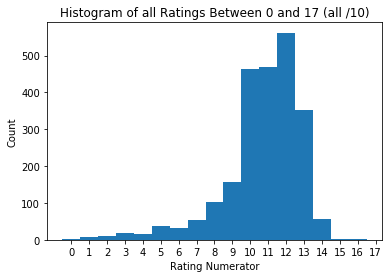

In [164]:
# let's plot the ratings that are less than 20
plt.hist(twitter_archive_master.rating_numerator[twitter_archive_master.rating_numerator <= 17], 
         bins=np.arange(0,18,step=1), align='left');
plt.xticks(np.arange(0,18,step=1));
plt.title('Histogram of all Ratings Between 0 and 17 (all /10)');
plt.xlabel('Rating Numerator');
plt.ylabel('Count');

##### Insight 1

Ratings 10/10 to 13/10 are by far the most popular, with 12/10 being the most-used rating. The mean rating is approximately 12.2/10. However, the median rating is 11/10.

From what I could tell, the ratings > 20 were mostly used for the significance of the number in relation to the photo or text, rather than an actual attempt at a rating. For instance, the rating of 1776/10 was used for a 'patriotic' dog, since 1776 is the year that the USA was founded.

Next, I'm curious about which kinds of dogs show up the most in these posts.

In [165]:
twitter_archive_master.prediction1.value_counts()

golden_retriever             149
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
Cardigan                      19
web_site                      19
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
teddy                         18
Shetland_sheepdog             18
Rottweiler                    17
Shih-Tzu                      17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

Wow, there are a lot of different possibilities? What are the top ten?

In [166]:
top_dog_counts = twitter_archive_master.prediction1.value_counts(normalize=True)

top_dogs = twitter_archive_master.prediction1.value_counts().index.tolist()

In [167]:
count = 0

while count < 10:
    print('{}: {}%'.format(top_dogs[count], round(top_dog_counts[count]*100,2)))
    count +=1

golden_retriever: 7.18%
Labrador_retriever: 4.82%
Pembroke: 4.29%
Chihuahua: 4.0%
pug: 2.75%
chow: 2.12%
Samoyed: 2.07%
toy_poodle: 1.88%
Pomeranian: 1.83%
cocker_spaniel: 1.45%


##### Insight 2

So, there is quite a variety. But, the most popular dog for this twitter account seems to be the golden retriever. And for those who don't know (as I didn't) what a Pembroke is, it's full name is a Pembroke Welsh Corgi.

I wonder what the realtionship is between favorite count and retweet count.

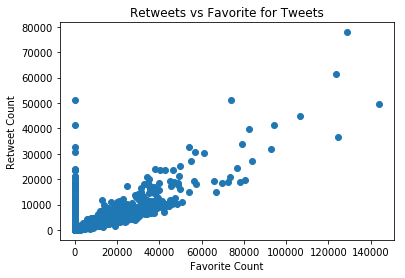

In [168]:
plt.scatter(twitter_archive_master.favorite_count, twitter_archive_master.retweet_count)
plt.xlabel('Favorite Count')
plt.ylabel('Retweet Count')
plt.title('Retweets vs Favorite for Tweets');

##### Insight 3

There looks to be a fairly linear relationship between how many favorites and how many retweets. However, there is that vertical bar of 0 'favorites' and yet lots of retweets, indicating that it's a little more complicated than that. I wonder if there's some purpose behind retweets besides simply liking a tweet. Granted, I'm not a Twitter user, so the common workings aren't familiar to me.

### Resources

1. Setting up Twitter API access - https://www.slickremix.com/docs/how-to-get-api-keys-and-tokens-for-twitter/
2. Getting tweet info by ID - https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
3. Writing to JSON files - http://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
4. Handling Twitter Rate Limit with a cursor - https://media.readthedocs.org/pdf/tweepy/latest/tweepy.pdf
5. Split list of IDs into blocks - https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
6. R/W JSON files - http://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
7. Constructing data frame with named columns from dict - https://stackoverflow.com/questions/20340844/pandas-create-named-columns-in-dataframe-from-dict
8. Quick way to get rid of rows with certain NaN columns - https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan
9. Get values from value_counts - https://stackoverflow.com/questions/35523635/extract-values-in-pandas-value-counts